In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import seaborn as sns
import sympy
import numpy as np
from sympy import symbols, diff, Matrix
from functools import partial
from collections import namedtuple
from jax.random import PRNGKey
import itertools
flatten = itertools.chain.from_iterable
import matplotlib.animation as animation
from IPython.display import Video
from mpl_toolkits.mplot3d import axes3d

#enable double precision
# from jax.config import config
# config.update("jax_enable_x64", True)

In [2]:
sns.set_context('notebook')
plt.rcParams['font.family'] = 'VictorMono Nerd Font'
plt.rcParams['mathtext.rm'] = 'VictorMono Nerd Font ExtraLight'
plt.rcParams['mathtext.it'] = 'VictorMono Nerd Font ExtraLight Italic'
plt.rcParams['mathtext.bf'] = 'VictorMono Nerd Font Light'
plt.rcParams['mathtext.default'] = 'rm'
# plt.rcParams['mathtext.fontset'] = 'stix'
SMALL_SIZE = 9
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In this notebook we demonstrate a simulation of one dimensional Fokker-Plank dynamics and Zakai nonlinear filtering dynamics.

In [3]:
# %cd ..

In [4]:
from numerical_pde_nonlinear_filtering import OneDNonLinearFilterPDE
from symbolic import SDE, column_polynomials_coefficients_one_D, backward_diffusion_one_D, lamdify, \
    column_polynomials_maximum_degree_one_D
from projection_filter.one_d_exponential_family_projection_filter import OneDimensionalSStarProjectionFilter
from sde import SDESolverTypes, sde_solver
from sde.common import time
from sde.wiener import scalar_wiener_process, multidimensional_wiener_process

In [5]:
t, x, y, dx, dy, dw, dv = symbols('t, x, y, dx, dy, dw, dv', real=True)
sigma = symbols('sigma', real=True)

In [6]:
@partial(jnp.vectorize,signature='(n),(n)->()')
def hellinger_distance(den_1,den_2):
    delta_sqrt_dens = jnp.sqrt(den_1) - jnp.sqrt(den_2)
    return 0.5*jnp.sum(jnp.square(delta_sqrt_dens)*pde_filter.dx)

In [7]:
# TO CHECK VALIDITY
# initial_mean = 0.
# sigma= 4.e-1 # default is 4e-1
# measurement_gain= 1.e0 # default is 1.
# nonlinear_measurement_map = lambda x: measurement_gain*x # ,-- To check validity set this to a linear measurement
# nt = 1500 # default is 4500, To check validity, set 40000
# dt = 1e-3 # default is 1e-4, To check validity, set 1e-5
# initial_mean= 0.
# sigma_ = 0.5
# mu_ = initial_mean
# natural_statistics_symbolic = Matrix([x, x**2])# 2th order 
# initial_condition=np.array([(mu_/sigma_),-1/(2*sigma_*sigma_)]) #Gaussian

# DEFAULT NONLINEAR OPTION (Double well)
sigma= 4.e-1 # default is 4e-1
initial_mean = 1.
measurement_gain= 0.8e0 # default is 1.
nonlinear_measurement_map = lambda x: measurement_gain*x**3
nt = 14000 # default is 4500, To check validity, set 40000
dt = 1e-4 # default is 1e-4, To check validity, set 1e-5
natural_statistics_symbolic = Matrix([x, x**2, x**3, x**4]) #DEFAULT 4th order
_alpha = 0.5
initial_condition=np.array([0.,2*_alpha, 0.,-1]) #DEFAULT


# NONLINEAR OPTION (as in Brigo)
# sigma= 4.e-1 # default is 4e-1
# initial_mean = 1.
# measurement_gain= 0.8e0 # default is 1.
# nonlinear_measurement_map = lambda x: measurement_gain*x**3
# nt = 14000 # default is 4500, To check validity, set 40000
# dt = 1e-4 # default is 1e-4, To check validity, set 1e-5
# natural_statistics_symbolic = Matrix([x, x**2, x**3, x**4]) #DEFAULT 4th order
# initial_condition=np.array([0.,-0.5, 0.,-0.5]) #DEFAULT

# DEFAULT NONLINEAR OPTION SIX DEGREE (Double well)
# sigma= 4.e-1 # default is 4e-1
# initial_mean = 1.
# measurement_gain= 0.8e0 # default is 1.
# nonlinear_measurement_map = lambda x: measurement_gain*x**3
# nt = 14000 # default is 4500, To check validity, set 40000
# dt = 1e-5 # default is 1e-4, To check validity, set 1e-5
# natural_statistics_symbolic = Matrix([x, x**2, x**3, x**4, x**5, x**6]) #DEFAULT 4th order
# _alpha = 0.5
# initial_condition=np.array([0.,-_alpha**4, 0.,2*_alpha*_alpha, 0., -1.]) 




@partial(jnp.vectorize, signature='(),()->(n)')
def f_dynamic(x, t):
    return jnp.array([0.])

@partial(jnp.vectorize, signature='(),()->(n)')
def g_dynamic(x,t):
    return jnp.array([sigma])


@partial(jnp.vectorize, signature='(),()->(n)')
def h_meas(x, t):
    return jnp.array([nonlinear_measurement_map(x)]) #<-- ini yang nongol di paper

def F(x,t):
    return jnp.array([0, nonlinear_measurement_map(x[0])])#<-- ini yang nongol di paper\ini yang nongol di paper
def G(x,t):
    return jnp.array([[sigma, 0.],[0., 1.]])



tspan = jnp.arange(nt)*dt
dw_ = multidimensional_wiener_process((nt, 2), dt, PRNGKey(4)) # 11 is good, alternative 5

X0 = np.array([initial_mean,nonlinear_measurement_map(initial_mean)])
X_integrated = sde_solver(F, G, X0, tspan, dw_, solver_type=SDESolverTypes.ItoEulerMaruyama)

dynamic_sde = SDE(drifts = [0,], diffusions=[sigma,], time=t, variables=[x,], brownians=dw)
measurement_sde = SDE(drifts = Matrix([nonlinear_measurement_map(x)]) , diffusions=Matrix([[1.]]), time=t, variables=[x,], brownians=dv)
measurement_record = X_integrated[:,1]

In [8]:
initial_mean

1.0

x_max = 8.
x_lim = (-x_max,x_max)
nb_of_points = 1000
bijection_type='arctanh'
if bijection_type = 'arctanh':
    def bijection(x):
        return jnp.arctanh(x)
else:
    def bijection(x):
        return x/(1-x*x)One observation is that, expansion of a natural statistics does not necessarily corresponds to a better estimation.!

In [9]:
x_max = 5.
x_lim = jnp.array([-x_max,x_max])
nb_of_points = jnp.array([1000],dtype=jnp.int32) #default 1000
dx =  2*x_max/nb_of_points
bijection_type='boyd'
if bijection_type == 'arctanh':
    def bijection(x,params):
        return jnp.arctanh(x)
elif bijection_type == 'boyd':
    def bijection(x,params):
        return x/((1-x*x)**1)
elif bijection_type == 'linear':
    def bijection(x,params):
        return x_max*x

In [10]:
em_pf_low = OneDimensionalSStarProjectionFilter(dynamic_sde,
                                         measurement_sde,
                                         natural_statistics_symbolic,
                                         constants={'sigma':sigma},
                                         initial_condition=initial_condition,
                                         measurement_record= measurement_record,
                                         delta_t= dt,
                                         nodes_number=12,
                                         bijection=bijection)

In [11]:
em_pf_med = OneDimensionalSStarProjectionFilter(dynamic_sde,
                                         measurement_sde,
                                         natural_statistics_symbolic,
                                         constants={'sigma':sigma},
                                         initial_condition=initial_condition,
                                         measurement_record= measurement_record,
                                         delta_t= dt,
                                         nodes_number=em_pf_low.exponential_density.nodes_number*4,
                                         bijection=em_pf_low.exponential_density.bijection)

In [12]:
em_pf_high = OneDimensionalSStarProjectionFilter(dynamic_sde,
                                         measurement_sde,
                                         natural_statistics_symbolic,
                                         constants={'sigma':sigma},
                                         initial_condition=initial_condition,
                                         measurement_record= measurement_record,
                                         delta_t= dt,
                                         nodes_number=em_pf_low.exponential_density.nodes_number*8,
                                         bijection=em_pf_low.exponential_density.bijection)

In [13]:
em_pf_low.propagate()
em_pf_med.propagate()
em_pf_high.propagate()
# em_pf_low.discrete_propagate()
# em_pf_med.discrete_propagate()
# em_pf_high.discrete_propagate()

In [14]:
# %timeit em_pf_high.propagate() #this can be misleading as jax is lazily executed

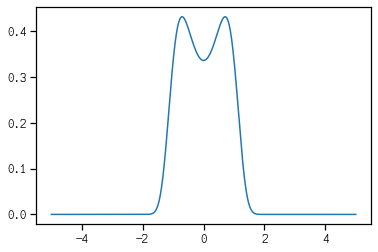

In [15]:
stat = em_pf_low.exponential_density.natural_statistics(jnp.linspace(x_lim[0],x_lim[1],nb_of_points[0],endpoint=True))
x_grid, initial_density = em_pf_low.exponential_density.get_density_values(x_lim,initial_condition,nb_of_points=nb_of_points,bijection_params=None)
# initial_density = initial_density/jnp.trapz(initial_density,dx=x_grid[1]-x_grid[0])#jnp.sum(initial_density*(x_grid[1]-x_grid[0]))
plt.plot(x_grid,initial_density)

In [16]:
pde_filter = OneDNonLinearFilterPDE(grids=x_grid,
                                    dynamic_drift=f_dynamic,
                                    dynamic_diffusion=g_dynamic,
                                    measurement_drift=h_meas,
                                    initial_condition=initial_density,
                                    delta_t=dt,
                                    measurement_record=measurement_record,
                                    measurement_stdev=1.)

In [17]:
density_history_zakai = pde_filter.propagate_zakai()
_, density_history_projection_low, _ = em_pf_low.get_density_values(x_lim,nb_of_points)
_, density_history_projection_med, _ = em_pf_med.get_density_values(x_lim,nb_of_points)
_, density_history_projection_high, _ = em_pf_high.get_density_values(x_lim,nb_of_points)

In [18]:
jnp.trapz(density_history_projection_low[-1],dx=x_grid[1]-x_grid[0])

DeviceArray(1.0207568, dtype=float32)

In [19]:
# %timeit pde_filter.propagate_zakai() #this can be misleading as jax is lazily executed

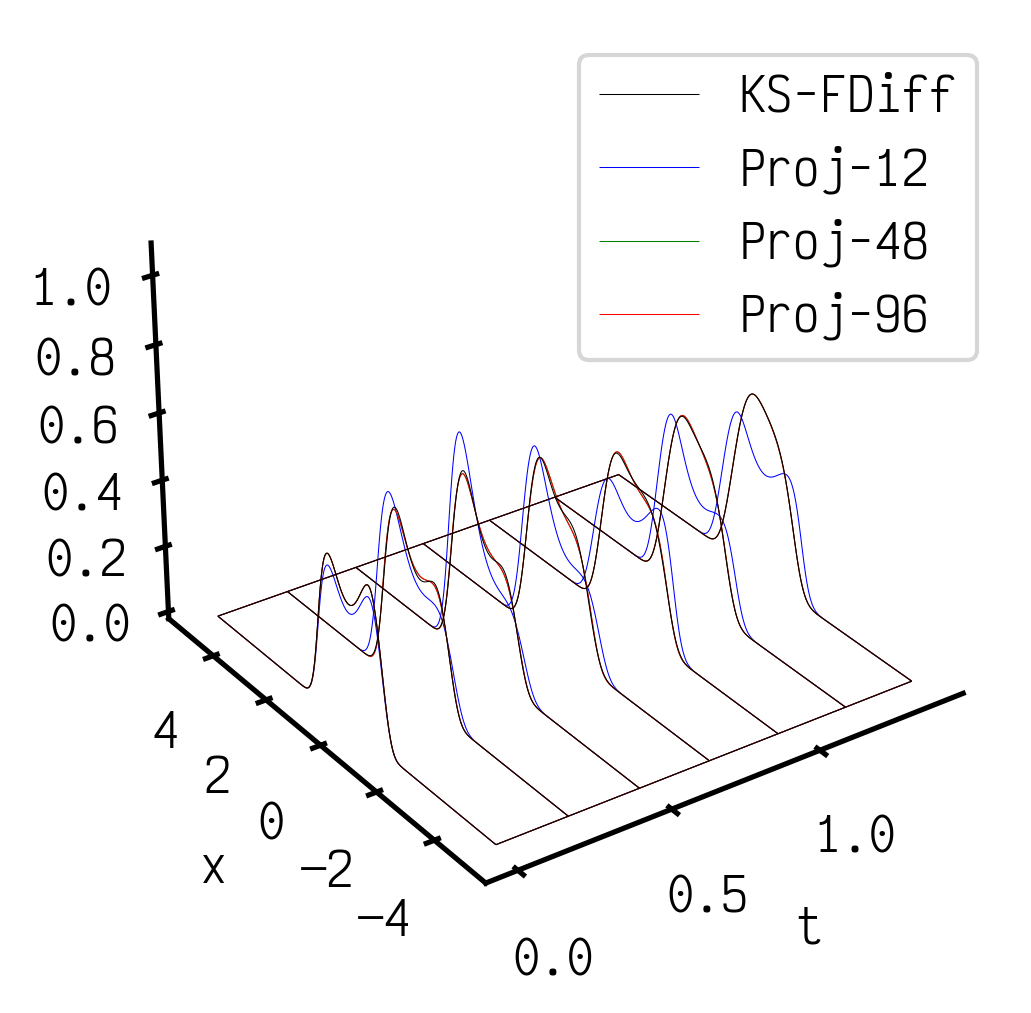

In [20]:
X_ = jnp.outer(jnp.ones(tspan.shape[0]),x_grid)
t_ = jnp.outer(tspan,jnp.ones(x_grid.shape[0]))
fig = plt.figure(dpi=300)
rcount = 6
ccount = 1
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(t_,X_, density_history_zakai, rcount=rcount,ccount=ccount, linewidth=0.25, color='k', label='KS-FDiff')
ax.plot_wireframe(t_[1:,],X_[1:,], density_history_projection_low, rcount=rcount,ccount=ccount, linewidth=0.25, color='b', label='Proj-{}'.format(em_pf_low.exponential_density.nodes_number))
ax.plot_wireframe(t_[1:,],X_[1:,], density_history_projection_med, rcount=rcount,ccount=ccount, linewidth=0.25, color='g', label='Proj-{}'.format(em_pf_med.exponential_density.nodes_number))
ax.plot_wireframe(t_[1:,],X_[1:,], density_history_projection_high, rcount=rcount,ccount=ccount, linewidth=0.25, color='r', label='Proj-{}'.format(em_pf_high.exponential_density.nodes_number))
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(30, 235)
white = (1.0, 1.0, 1.0, 1.0)
ax.w_xaxis.set_pane_color(white)
ax.w_yaxis.set_pane_color(white)
ax.w_zaxis.set_pane_color(white)
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.legend()
plt.savefig('wire_frame_comparison_zakai_brigo_{}.pdf'.format(bijection_type))

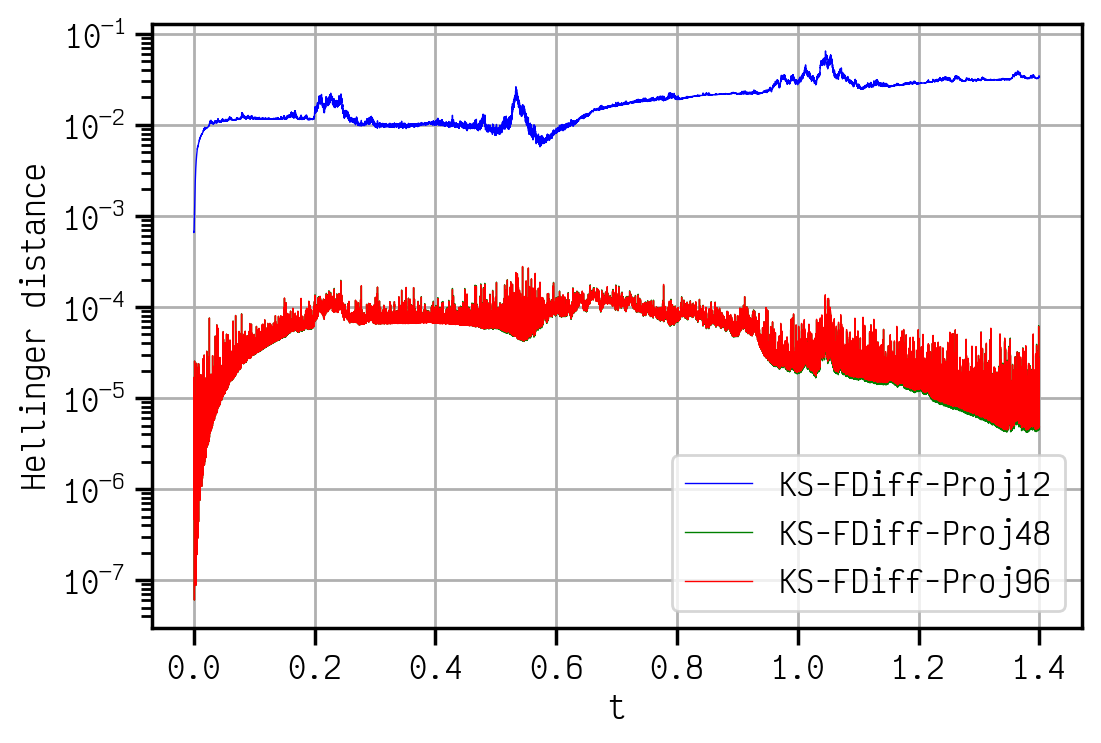

In [21]:
hell_dist_low = hellinger_distance(density_history_projection_low,density_history_zakai[1:])
hell_dist_med = hellinger_distance(density_history_projection_med,density_history_zakai[1:])
hell_dist_high = hellinger_distance(density_history_projection_high,density_history_zakai[1:])
plt.figure(dpi=200)
until_time_index = nt
plt.semilogy(tspan[1:until_time_index+1],hell_dist_low[:until_time_index],linewidth=0.5, color='b', label='KS-FDiff-Proj{}'.format(em_pf_low.exponential_density.nodes_number))
plt.semilogy(tspan[1:until_time_index+1],hell_dist_med[:until_time_index],linewidth=0.5, color='g', label='KS-FDiff-Proj{}'.format(em_pf_med.exponential_density.nodes_number))
plt.semilogy(tspan[1:until_time_index+1],hell_dist_high[:until_time_index],linewidth=0.5, color='r', label='KS-FDiff-Proj{}'.format(em_pf_high.exponential_density.nodes_number))
plt.xlabel('t')
plt.ylabel('Hellinger distance')
plt.grid()
plt.legend()
plt.savefig('Hellinger_wrt_Zakai_{}.pdf'.format(bijection_type))

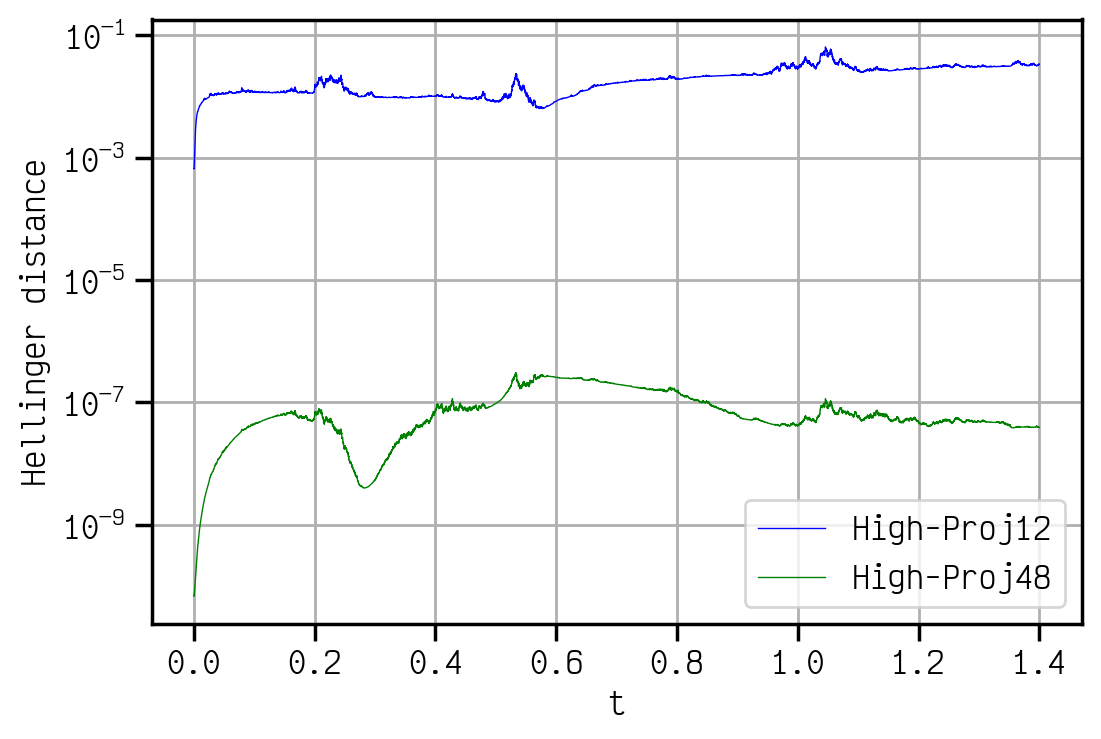

In [22]:
hell_dist_low_high = hellinger_distance(density_history_projection_low,density_history_projection_high)
hell_dist_med_high = hellinger_distance(density_history_projection_med,density_history_projection_high)
plt.figure(dpi=200)
until_time_index = nt
plt.semilogy(tspan[1:until_time_index+1],hell_dist_low_high[:until_time_index],linewidth=0.5, color='b', label='High-Proj{}'.format(em_pf_low.exponential_density.nodes_number))
plt.semilogy(tspan[1:until_time_index+1],hell_dist_med_high[:until_time_index],linewidth=0.5, color='g', label='High-Proj{}'.format(em_pf_med.exponential_density.nodes_number))
plt.xlabel('t')
plt.ylabel('Hellinger distance')
plt.grid()
plt.legend()
plt.savefig('Hellinger_wrt_High_{}.pdf'.format(bijection_type))

delta mean = 2.4586915969848633e-06


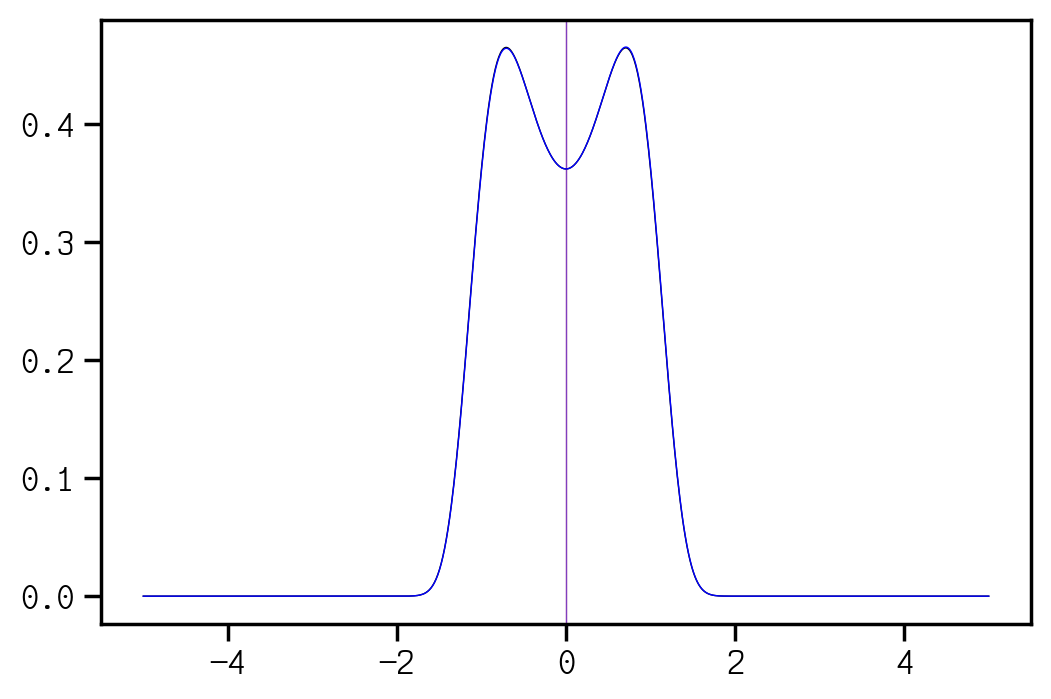

In [23]:
plt.figure(dpi=200)
time_index=0
time_shift=1
density_history_projection = density_history_projection_high
mode_zakai = x_grid[jnp.argmax(density_history_zakai[time_index+time_shift])]
mode_brigo = x_grid[jnp.argmax(density_history_projection[time_index])]
mean_zakai = jnp.sum(x_grid*density_history_zakai[time_index+time_shift])/sum(density_history_zakai[time_index+time_shift])
mean_brigo = jnp.sum(x_grid*density_history_projection[time_index])/sum(density_history_projection[time_index])
plt.plot(x_grid,density_history_zakai[time_index+time_shift], linewidth=0.5, color='k')
plt.axvline(mean_zakai, linewidth=0.5, color='r', alpha=0.5)
plt.plot(x_grid,density_history_projection[time_index], linewidth=0.5, color='b')
plt.axvline(mean_brigo, linewidth=0.5, color='b', alpha=0.5)
print('delta mean = {}'.format(jnp.mean(density_history_zakai[time_index+time_shift])-jnp.mean(density_history_projection[time_index])))

In [24]:
# fig = plt.figure(dpi=150)
# skip=25
# def animate(i):
#     plt.cla()
#     time_index = i*skip
#     mean_zakai = jnp.sum(x_grid*density_history_zakai[time_index+time_shift])/sum(density_history_zakai[time_index+time_shift])
#     mean_brigo = jnp.sum(x_grid*density_history_projection_low[time_index])/sum(density_history_projection_low[time_index])
#     plt.plot(x_grid, density_history_zakai[time_index+time_shift], c='r', linewidth=0.5, label='Zakai')
#     plt.axvline(mean_zakai, linewidth=0.5, color='r')
#     plt.plot(x_grid, density_history_projection_low[time_index], c='b', linewidth=0.5, label='Brigo')
#     plt.axvline(mean_brigo, linewidth=0.5, color='b')
#     plt.xlabel('x, t={}'.format(dt*i*skip))    
#     plt.ylabel('$p_t$')
#     plt.legend()
    
# anim = animation.FuncAnimation(fig, animate,frames=density_history_zakai.shape[0]//skip, interval=1000)
# writervideo = animation.FFMpegWriter(fps=10) 
# anim.save('zakai__vs_projection_example_1_Brigo_1996.mp4', writer=writervideo)

In [25]:
# Video('zakai__vs_projection_example_1_Brigo_1996.mp4', embed=True)

# Check validity
By simulating projection filter for linear system with linear measurement on Gaussian family.

Beware that the Zakai filter implementation still wrong!

In [38]:
def scalar_kalman_filter(A,C,Q,R,y,x_init,p_init):
    x = np.zeros(y.shape[0]+1)
    p = np.zeros(y.shape[0]+1)
    x[0] = x_init
    p[0] = p_init
    for i in range(y.shape[0]):
        x_pred = A*x[i]
        p_pred = A*p[i]*A + Q
        y_tilde = y[i]-C*x_pred
        s = C*p_pred*C + R
        K = p_pred*C/s
        x[i+1] = x_pred + K*y_tilde
        p[i+1] = (1-K*C)*p_pred
    return x[1:],p[1:]

dy_ = jnp.diff(measurement_record)
x_,p_ = scalar_kalman_filter(np.exp(0),measurement_gain*dt,(sigma**2)*dt,dt,np.array(dy_),mu_,sigma_**2)

In [40]:
x_grid = pde_filter.grids
density_history_zakai.shape

(1500, 1000)

In [47]:
# np.vectorize?

In [48]:
# @partial(np.vectorize,signature='(n)->(),()',excluded=[1,2])
# def get_mean_and_variance(a_density,x_grid,dx):
#     mean = jnp.trapz(a_density*x_grid,dx=dx)
#     var = jnp.trapz(a_density*x_grid*x_grid,dx=dx)
#     return mean, var

In [49]:
# mean_zakai,var_zakai = get_mean_and_variance(density_history_zakai,pde_filter.grids,pde_filter.dx)
# std_zakai = np.sqrt(var_zakai)

In [50]:
# std_zakai = np.sqrt(var_zakai)

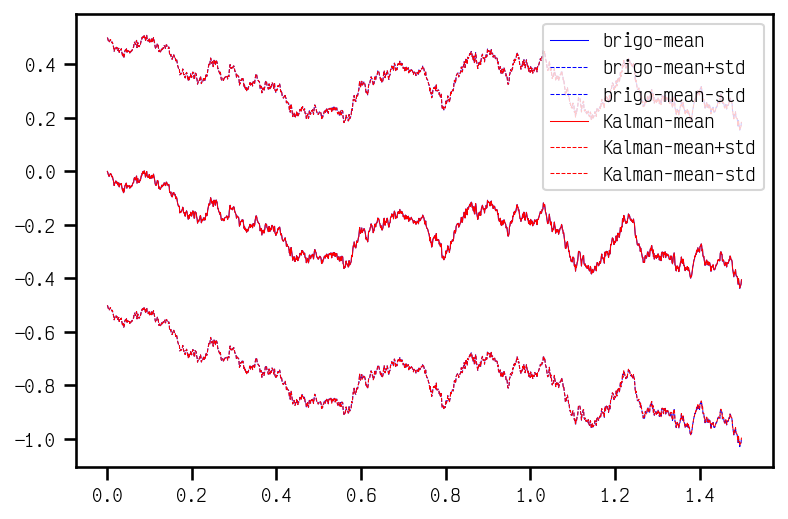

In [53]:
em_pf = em_pf_low
projection_mean = -em_pf.state_history[:,0]/(2*em_pf.state_history[:,1])
projection_var = -0.5/em_pf.state_history[:,1]

plt.figure(dpi=150)
# plt.plot(tspan,x_integrated[:,0],linewidth=0.5,color='k')
# plt.plot(tspan[1:],mean_zakai[1:],linewidth=0.5, color='g',label='zakai-mean')
# plt.plot(tspan[1:],mean_zakai[1:]+std_zakai[1:], color='g',linewidth=0.5, linestyle='dashed',label='zakai-mean+std')
# plt.plot(tspan[1:],mean_zakai[1:]-std_zakai[1:], color='g',linewidth=0.5, linestyle='dashed',label='zakai-mean-std')
plt.plot(tspan[1:],projection_mean,linewidth=0.5, color='b',label='brigo-mean')
plt.plot(tspan[1:],projection_mean+jnp.sqrt(projection_var), color='b',linewidth=0.5, linestyle='dashed',label='brigo-mean+std')
plt.plot(tspan[1:],projection_mean-jnp.sqrt(projection_var), color='b',linewidth=0.5, linestyle='dashed',label='brigo-mean-std')
plt.plot(tspan[1:],x_,linewidth=0.5,color='r',label='Kalman-mean')
plt.plot(tspan[1:],x_+np.sqrt(p_),linewidth=0.5,color='r', linestyle='dashed',label='Kalman-mean+std')
plt.plot(tspan[1:],x_-np.sqrt(p_),linewidth=0.5,color='r', linestyle='dashed',label='Kalman-mean-std')
plt.legend()